In [1]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import datetime
import pyproj

In [2]:
# Read pipe network and leaks loc
pipes_raw = gpd.read_file("../data/shp/Tuberias.shp")
leaks_raw = pd.read_excel("../data/raw/Ordenes Fugas Ejecutadas Dic2022 XY.xlsx")

In [3]:
# Define geometry from coords in leaks dataset
leaks_clean = leaks_raw.copy()
leaks_clean["geometry"] = gpd.points_from_xy(leaks_clean["X"], leaks_clean["Y"])

# Create gepandas gpd 
leaks_clean = gpd.GeoDataFrame(leaks_clean, geometry = "geometry")
pipes_clean = pipes_raw.copy()

In [4]:
pipes_clean.crs

<Compound CRS: COMPD_CS["WGS 84 / UTM zone 13N + NAVD88 height",P ...>
Name: WGS 84 / UTM zone 13N + NAVD88 height
Axis Info [cartesian|vertical]:
- [east]: Easting (metre)
- [north]: Northing (metre)
- [up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
Sub CRS:
- WGS 84 / UTM zone 13N
- NAVD88 height

In [5]:
# leaks_clean = leaks_clean.set_crs("WGS 84")
leaks_clean.crs

In [ ]:
#pipes_clean.to_crs(4326)
#leaks_clean.to_crs(4326)

# Download 10x10 patch from GEE

In [6]:
ee.Initialize()
Map = geemap.Map()

In [7]:
# Coords of leaks
leak_lat = leaks_clean["Y"][0]
leak_lon = leaks_clean["X"][0]

# Transform to degrees
transformer = pyproj.Transformer.from_crs("epsg:32613", "epsg:4326")
leak_lon, leak_lat = transformer.transform(leak_lon, leak_lat)

# Point of leak
leak_poi = ee.Geometry.Point([leak_lat, leak_lon])

# Date of leak
end_date = leaks_clean["FECHALEGALIZACION"][0]
start_date = end_date - datetime.timedelta(10)

end_date = str(end_date)[:10]
start_date = str(start_date)[:10]

print((start_date, end_date))
print((leak_lat, leak_lon))

('2022-11-27', '2022-12-07')
(-102.27943290775767, 21.935910837898607)


In [8]:
collection = ee.ImageCollection("COPERNICUS/S2_SR")\
                .filterBounds(leak_poi)\
                .filterDate(ee.Date(start_date), ee.Date(end_date))

print("Images: ", collection.size().getInfo())

collection_list = collection.toList(collection.size())

Images:  4


In [10]:
bands = ["B4", "B3", "B2"]

img0 = ee.Image(collection_list.get(0))
img0 = img0.select(bands)

# Clip patch size
img0 = img0.clip(leak_poi.buffer(200).bounds())


viz_params = {
    "bands": ["B4", "B3", "B2"],
    "min": 0,
    "max": 3000
}

# Map.setCenter(leak_lat, leak_lon)
Map.addLayer(img0, viz_params, "img0")
Map.centerObject(img0)
Map

Map(bottom=3670659.0, center=[21.929391291441927, -102.28211402893068], controls=(WidgetControl(options=['posi…

In [ ]:
# Check crs of satellite image
img0.crs.data

## Clip GeoTIFF with rasterio

In [1]:
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.crs import CRS
from shapely.geometry import box
from shapely.geometry import Point
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import matplotlib.pyplot as plt

<AxesSubplot: >

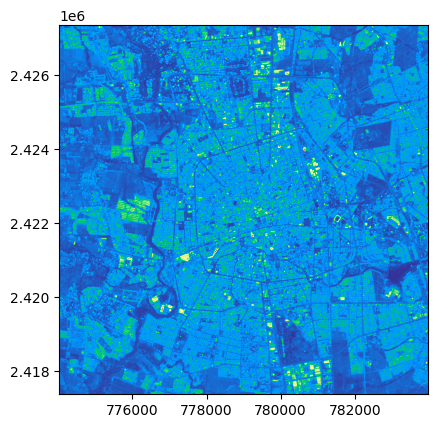

In [153]:
# Read geotiff
img1 = rio.open("../data/images/20221210T171721_20221210T172008_T13QGE.B2.tif")



show((img1, 1), cmap = "terrain", ax = ax)
# geo.plot(ax = ax, edgecolor = "red")

In [3]:
poi = Point(783554.1499037556, 2419813.8500305936)
poi_patch = poi.buffer(200, cap_style = 3)

In [71]:
# bbox
minx, miny = 778000, 2421000
maxx, maxy = 781000, 2424000
poi_patch = box(minx, miny, maxx, maxy)

In [4]:
geo = gpd.GeoDataFrame({"geometry": poi_patch}, index = [0], crs = from_epsg(32613))

In [125]:
geo

,geometry
0,"POLYGON ((783554.250 2419813.850, 783554.249 2..."


<AxesSubplot: >

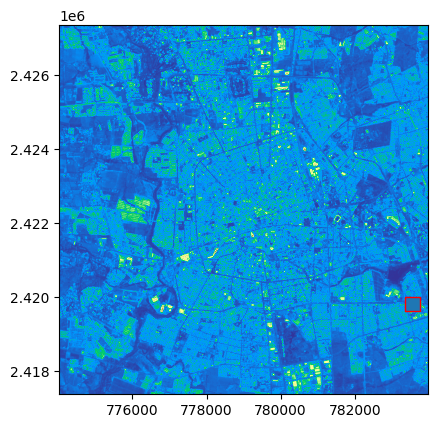

In [154]:
# Lets plot the patch over the full image
fig, ax = plt.subplots()
show((img1, 1), cmap = "terrain", ax = ax)
geo.plot(ax = ax, edgecolor = "red")

<xarray.DataArray (band: 1, y: 41, x: 41)>
[1681 values with dtype=uint16]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 7.834e+05 7.834e+05 ... 7.837e+05 7.838e+05
  * y            (y) float64 2.42e+06 2.42e+06 2.42e+06 ... 2.42e+06 2.42e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0
    _FillValue:              0


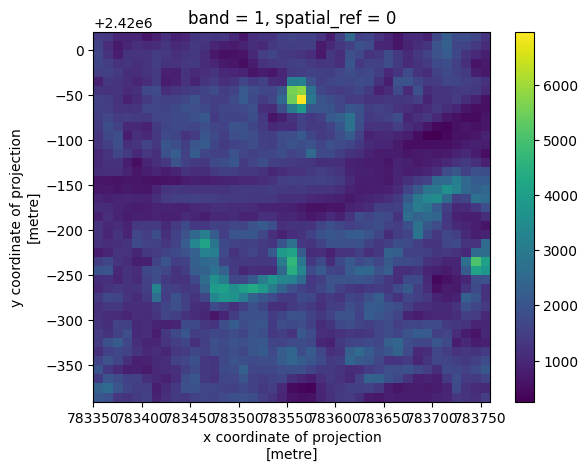

In [5]:
import rioxarray
img1 = rioxarray.open_rasterio("../data/images/20221210T171721_20221210T172008_T13QGE.B2.tif")

# Crop raster with bounding box
img1_clip = img1.rio.clip_box(*geo.total_bounds)
print(img1_clip)
img1_clip.plot()

In [6]:
# Save rioxarray patch
img1_clip.rio.to_raster("../data/patches/leak_no_patch_riox.tif")

In [74]:
img1.crs.data

{'init': 'epsg:32613'}

In [75]:
geo = geo.to_crs(crs = img1.crs.data)
geo

c:\Users\Erick\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry
0,"POLYGON ((781000.000 2421000.000, 781000.000 2..."


In [76]:
img1.bounds

BoundingBox(left=774030.0, bottom=2417380.0, right=783980.0, top=2427350.0)

In [77]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [78]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[781000.0, 2421000.0], [781000.0, 2424000.0], [778000.0, 2424000.0], [778000.0, 2421000.0], [781000.0, 2421000.0]]]}]


In [86]:
out_img, out_transform = mask(dataset = img1, shapes=coords, crop=True)


In [87]:
# Copy metadata from full image
out_meta = img1.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 995, 'height': 997, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 774030.0,
       0.0, -10.0, 2427350.0)}


In [88]:
# Parse EPSG code 
epsg_code = int(img1.crs.data["init"][5:])
epsg_code

32613

In [114]:
# Update metadata
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": CRS.from_epsg(epsg_code).to_proj4()}
                 )

In [115]:
# Update metadata
with rio.open("../data/patches/leak_no_patch2.tif", "w", **out_meta) as dest:
    dest.write(out_img)

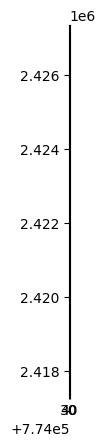

<AxesSubplot: >

In [116]:
patch_img1 = rio.open("../data/patches/leak_no_patch.tif")
show((patch_img1, 1), cmap = "terrain")

In [117]:
out_transform

Affine(10.0, 0.0, 778000.0,
       0.0, -10.0, 2424000.0)

In [118]:
patch_img1.bounds

BoundingBox(left=774030.0, bottom=2417380.0, right=774040.0, top=2427350.0)